# Titanic dataset
W tym notebook'u postaram się wytrenować model, który będzie w stanie odgadnąć, czy dana osoba przeżyła katastrofę Titanic'a na podstawie różnych danych na temat tej osoby.

## 1. Importowanie zależności
Żeby wykonać to zadanie, będę potrzebował kilku zależności, takich jak pandas, numpy, czy matplotlib (żeby zwizualizować dane)

In [1]:
import numpy as np
np.random.seed(2019)
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from stringcase import snakecase
from collections import defaultdict

%matplotlib inline

## 2. Załadowanie danych
Aby załadować potrzebne mi dane, posłużę się danymi udostępnionymi przez [Kaggle](https://www.kaggle.com/c/titanic/data). Ładuję jedynie dane treningowe, ponieważ dla danych testowych, Kaggle nie podaje nam target feature (o to chodzi w konkursie). W dalszej części podzielę dane treningowe na 2 zbiory, żeby móc zwalidować model.

In [2]:
train = pd.read_csv('train.csv')

## 3. Zdefiniowanie natury problemu
W tym przypadku nasz problem ma dosyć jasną metrykę sukcesu. Chcemy **zaklasyfikować** każdego z pasażerów jako osobę, która przeżyła katastrofę lub która nie przeżyła. Jest to klasyfikacja binarna.

## 4. Eksploracja danych
Jeżeli mamy już zdefiniowany problem oraz potrzebne dane, to warto by było bliżej im się przyjrzeć, żeby wiedzieć, z czym będziemy pracować.

In [3]:
train.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
567,568,0,3,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",female,29.0,0,4,349909,21.0750,NaN,S
332,333,0,1,"Graham, Mr. George Edward",male,38.0,0,1,PC 17582,153.4625,C91,S
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
141,142,1,3,"Nysten, Miss. Anna Sofia",female,22.0,0,0,347081,7.7500,NaN,S
397,398,0,2,"McKane, Mr. Peter David",male,46.0,0,0,28403,26.0000,NaN,S
726,727,1,2,"Renouf, Mrs. Peter Henry (Lillian Jefferys)",female,30.0,3,0,31027,21.0000,NaN,S
719,720,0,3,"Johnson, Mr. Malkolm Joackim",male,33.0,0,0,347062,7.7750,NaN,S
742,743,1,1,"Ryerson, Miss. Susan Parker ""Suzette""",female,21.0,2,2,PC 17608,262.3750,B57 B59 B63 B66,C
33,34,0,2,"Wheadon, Mr. Edward H",male,66.0,0,0,C.A. 24579,10.5000,NaN,S
42,43,0,3,"Kraeff, Mr. Theodor",male,NaN,0,0,349253,7.8958,NaN,C


Oprócz oczywistych danych, takich jak `PassengerId, Survived, Name, etc.`, znajduje się kilka bardziej "tajemniczych" nazw kolumn. Sprawdzając to na Kaggle, dowiadujemy się, że:

***pclass*** - jest to oznaczenie klasy socjo-ekonomicznej danego pasażera, gdzie:
    - 1 = klasa wyższa
    - 2 = klasa średnia
    - 3 = klasa niższa
    
***parch*** - oznacza relację rodzić-dziecko (innymi słowy, w przypadku dorosłego, z iloma dziećmi podróżował, a w przypadku dzieci - ilu rodziców podróżowało z tym dzieckiem. Niektóre dzieci podróżowały z opiekunkami - dla nich wartość tej kolumny wynosi 0)

***sibsp*** - oznacza relację rodzeństwo-małżonek/małżonka (podobnie jak w przypadku parch). Narzeczeni lub "nieformalni" partnerzy nie byli brani pod uwagę.

***embarked*** - nazwa portu, z którego dany pasażer wyruszył w podróż (C = Cherbourg, Q = Queenstown, S = Southampton)


Sprawdźmy nasze dane nieco dokładniej

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Najistotniejszą rzeczą, którą można wywnioskować z powyższych informacji jest to, że mamy puste wartości w kolumnach **Age** i **Cabin**. Rozwiążemy tę sytuację podstawiając w miejsce pustych wartości *-1*.

In [6]:
train.fillna(-1, inplace=True)
train.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
92,93,0,1,"Chaffee, Mr. Herbert Fuller",male,46.0,1,0,W.E.P. 5734,61.1750,E31,S
681,682,1,1,"Hassab, Mr. Hammad",male,27.0,0,0,PC 17572,76.7292,D49,C
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,-1,C
192,193,1,3,"Andersen-Jensen, Miss. Carla Christine Nielsine",female,19.0,1,0,350046,7.8542,-1,S
537,538,1,1,"LeRoy, Miss. Bertha",female,30.0,0,0,PC 17761,106.4250,-1,C
873,874,0,3,"Vander Cruyssen, Mr. Victor",male,47.0,0,0,345765,9.0000,-1,S
156,157,1,3,"Gilnagh, Miss. Katherine ""Katie""",female,16.0,0,0,35851,7.7333,-1,Q
427,428,1,2,"Phillips, Miss. Kate Florence (""Mrs Kate Louis...",female,19.0,0,0,250655,26.0000,-1,S
787,788,0,3,"Rice, Master. George Hugh",male,8.0,4,1,382652,29.1250,-1,Q
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0000,-1,S


Jak widać powyżej - puste wartości zostały zatąpione przez *-1*. W ten sposób model nie pomyli ich z innymi wartościami dostępnymi w tym dataset'cie

Wygodniej by było, gdybyśmy jeszcze ustandaryzowali sobie nazwy kolumn. Zamieńmy nazwy kolumn w dataset'cie z `camelCase` na `snake_case`. Wykorzystam do tego bibliotekę `stringcase`, którą wcześniej zainstalowałem za pomocą komendy `pip install stringcase`

In [7]:
train.rename(columns=lambda x: snakecase(x), inplace=True)

In [8]:
train.sample()

,passenger_id,survived,pclass,name,sex,age,sib_sp,parch,ticket,fare,cabin,embarked
623,624,0,3,"Hansen, Mr. Henry Damsgaard",male,21.0,0,0,350029,7.8542,-1,S


## Wizualizacja

Warto zbadać dane "wzrokowo", posługując się wykresami. Często w ten sposób dużo łatwiej wychwycić ciekawe zależności. Na początek sprawdźmy jak wyglądał rozkład ocalałych pasażerów, biorąc pod uwagę ich płeć.

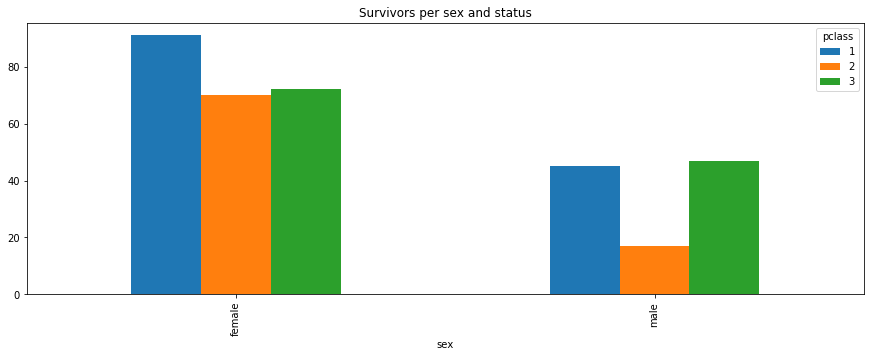

In [9]:
survivors = train[train['survived'] == 1]
grouped = survivors.groupby(['sex', 'pclass'])['survived'].agg('sum').unstack()
grouped.plot(kind='bar', figsize=(15, 5), title='Survivors per sex and status');

Na pierwszy rzut oka widzimy, że wśród ocalałych pasażerów, większość stanowią kobiety. Co ciekawe - nasuwa się również obserwacja, że w przypadku kobiet, należność do wyższej klasy społecznej również miała wpływ na ich szanse na przeżycie katastrofy. W przypadku mężczyzn proporcje ocalałych biorąc pod uwagę klasę społeczną nie miały większego znaczenia, z wyjątkiem panów należących do klasy śreniej.

Pojawia się jednak pewna wątpliwość - widzimy proporcje ocalałych ze względu na płeć, ale wyciągnięcie pochopnych wniosków mogłoby być zniekształcaniem rzeczywistości. Co jeżeli większość pasażerów na Titanic'u generalnie stanowiły kobiety? Sprawdźmy to.

In [10]:
train['sex'].value_counts()

male      577
female    314
Name: sex, dtype: int64

Jak widać, w większości pasażerami byli mężczyźni. Skąd więc taka dysproporcja wśród ocalałych? Moja teza jest taka, że o takiej statystyce zadecydowała zasada "najpierw kobiety i dzieci" oraz skłonność mężczyzn do ustępowania kobietom lepszych miejsc (jak chociażby Jack w filmie ;)). Skoro wspomnieliśmy o dzieciach, to z ciekawości sprawdźmy również jak wyglądała sprawa biorąc pod uwagę wiek.

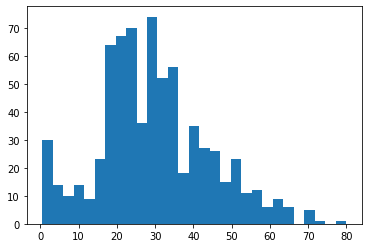

In [11]:
plt.hist(train['age'][train['age'] >= 0], bins=29);

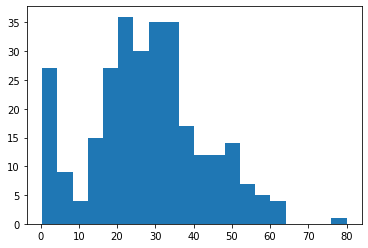

In [12]:
plt.hist(survivors['age'][survivors['age'] >= 0], bins=20);

Patrząc na dwa powyższe histogramy, rzeczywiście widać, że przeżyło relatywnie dużo noworodków i dzieci do 10-tego roku życia. Patrząc na pozostałe przedziały, proporcja wszystkich pasażerów do tych, którzy przeżyli wygląda dosyć równomiernie.

Kolejną cechą, która przykuwa moją uwagę jest relacja parent-child. Wiemy już, że dzieci miały relatywnie duże szanse na przeżycie, jednak czy samo podróżowanie z dzieckiem mogło mieć wpływ na to, czy dorosły przeżył? 

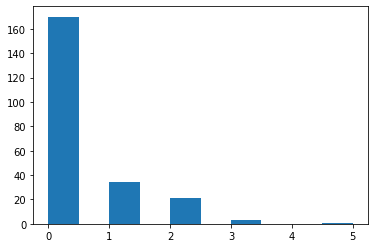

In [13]:
plt.hist(survivors['parch'][survivors['age'] >= 18]); 

Wygląda na to, że w większości przeżyli dorośli, którzy nie podróżowali z dziećmi. Jednak znów - wcale nie mamy pewności, że rozkład pomiędzy jedną a drugą grupą był równomierny (prawdopodobnie nie).

Spróbujmy poszukać dodatkowych cech, które mogą pomóc w predykcji. Przeglądając dane nieco wyżej, możemy zauważyć, że pasażerowie mieli różne tytułu (Miss, Dr, Master, itp.). Sprawdźmy, czy może to wpłynąć na nasz wynik.

In [14]:
train['title'] = train['name'].map(lambda x: x.split(',')[1].split('.')[0].strip())

In [15]:
train['title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Mlle              2
Major             2
Jonkheer          1
Ms                1
Capt              1
Lady              1
the Countess      1
Don               1
Sir               1
Mme               1
Name: title, dtype: int64

Jak widać, jest kilka bardzo popularnych tytułów, natomiast zdecydowana większość pojawia się mniej niż 10 razy. Proponuję zostawić 6 najbardziej popularnych, a resztę umieścić zbiorczej kategorii `other` 

In [16]:
top_titles = list(train['title'].value_counts().head(6).keys())

title_norm = defaultdict(lambda: 'other', dict(zip(top_titles, top_titles)))
train['title_norm'] = train['title'].map(title_norm)
train['title_norm'].value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
other      14
Dr          7
Rev         6
Name: title_norm, dtype: int64

Znormalizujmy teraz nasze tytuły, przepuszczając je przez metodę `factorize()`

In [17]:
train['title_norm_cat'] = train['title_norm'].factorize()[0]

Myślę, że warto przyjrzeć się teraz wiekowi pasażerów pod względem tytułów.

In [18]:
mean_age_by_title = train.groupby('title_norm').agg(np.mean)['age'].to_dict()
mean_age_by_title

{'Dr': 35.857142857142854,
 'Master': 4.01675,
 'Miss': 17.26923076923077,
 'Mr': 24.687620889748548,
 'Mrs': 30.88,
 'Rev': 43.166666666666664,
 'other': 42.214285714285715}

In [19]:
median_age_by_title = train.groupby('title_norm').agg(np.mean)['age'].to_dict()
median_age_by_title

{'Dr': 35.857142857142854,
 'Master': 4.01675,
 'Miss': 17.26923076923077,
 'Mr': 24.687620889748548,
 'Mrs': 30.88,
 'Rev': 43.166666666666664,
 'other': 42.214285714285715}

In [20]:
train['age_mean'] = train.title_norm.map(mean_age_by_title)
train['age_median'] = train.title_norm.map(median_age_by_title)
train['age_median']

0      24.687621
1      30.880000
2      17.269231
3      30.880000
4      24.687621
         ...    
886    43.166667
887    17.269231
888    17.269231
889    24.687621
890    24.687621
Name: age_median, Length: 891, dtype: float64

## Przygotowanie danych

In [21]:
train.sample(10)

,passenger_id,survived,pclass,name,sex,age,sib_sp,parch,ticket,fare,cabin,embarked,title,title_norm,title_norm_cat,age_mean,age_median
568,569,0,3,"Doharr, Mr. Tannous",male,-1.0,0,0,2686,7.2292,-1,C,Mr,Mr,0,24.687621,24.687621
62,63,0,1,"Harris, Mr. Henry Birkhardt",male,45.0,1,0,36973,83.4750,C83,S,Mr,Mr,0,24.687621,24.687621
793,794,0,1,"Hoyt, Mr. William Fisher",male,-1.0,0,0,PC 17600,30.6958,-1,C,Mr,Mr,0,24.687621,24.687621
117,118,0,2,"Turpin, Mr. William John Robert",male,29.0,1,0,11668,21.0000,-1,S,Mr,Mr,0,24.687621,24.687621
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.0000,C23 C25 C27,S,Miss,Miss,2,17.269231,17.269231
796,797,1,1,"Leader, Dr. Alice (Farnham)",female,49.0,0,0,17465,25.9292,D17,S,Dr,Dr,6,35.857143,35.857143
418,419,0,2,"Matthews, Mr. William John",male,30.0,0,0,28228,13.0000,-1,S,Mr,Mr,0,24.687621,24.687621
168,169,0,1,"Baumann, Mr. John D",male,-1.0,0,0,PC 17318,25.9250,-1,S,Mr,Mr,0,24.687621,24.687621
422,423,0,3,"Zimmerman, Mr. Leo",male,29.0,0,0,315082,7.8750,-1,S,Mr,Mr,0,24.687621,24.687621
150,151,0,2,"Bateman, Rev. Robert James",male,51.0,0,0,S.O.P. 1166,12.5250,-1,S,Rev,Rev,5,43.166667,43.166667


In [22]:
black_list = ['passenger_id', 'name', 'survived', 'id', 'ticket', 'cabin', 'title', 'title_norm']
train = pd.get_dummies(train, prefix='sex', columns=['sex'], drop_first=True)
train = pd.get_dummies(train, prefix='embarked', columns=['embarked'], drop_first=True)
feats = [feat for feat in train.columns if feat not in black_list]
print(feats)
y = train['survived'].values
X = train[feats].values

['pclass', 'age', 'sib_sp', 'parch', 'fare', 'title_norm_cat', 'age_mean', 'age_median', 'sex_male', 'embarked_C', 'embarked_Q', 'embarked_S']


## Cross-walidacjia i trenowanie pierwszych modeli

In [26]:
cv = StratifiedKFold(n_splits=5, random_state=2019, shuffle=True)
models = [
    DecisionTreeClassifier(random_state=2019),
    LogisticRegression(random_state=2019, solver='lbfgs', max_iter=1000),
    RandomForestClassifier(random_state=2019, n_estimators=100),
    ExtraTreesClassifier(random_state=2019, n_estimators=100),
    XGBClassifier(random_state=2019)
]
def train_models_and_print_score(models, cv, X, y):
    for model in models:
        scores=[]
        for (train_ids, test_ids) in cv.split(X, y):
            model.fit(X[train_ids], y[train_ids])
            y_pred = model.predict(X[test_ids]) 
            scores.append(accuracy_score(y[test_ids], y_pred))

        print('{0} score:'.format(type(model).__name__), np.mean(scores), 'Std error:', np.std(scores))
        
train_models_and_print_score(models, cv, X, y)

DecisionTreeClassifier score: 0.7978564693006953 Std error: 0.03458118082774375
LogisticRegression score: 0.7934123038371339 Std error: 0.024060517607751353
RandomForestClassifier score: 0.813606063152997 Std error: 0.0322270720343562
ExtraTreesClassifier score: 0.7978753005102868 Std error: 0.031781392580229995
XGBClassifier score: 0.8282002505863032 Std error: 0.02811185857871466
